In [1]:
import os
import sys
import numpy as np
import tqdm
from typing import Optional, Union, List

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import sys

module_path = os.path.abspath(
    os.path.join(
        "/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.append(
    os.path.abspath(
        os.path.join(
            "/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/torch_contextual_gate_calibration"
        )
    )
)

from basis_gate_library import FixedFrequencyTransmon
from helper_functions import (
    remove_unused_wires,
    get_control_channel_map,
    get_solver_and_freq_from_backend,
)
from quantumenvironment import QuantumEnvironment

import jax

jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
# import Array and set default backend
from qiskit_dynamics.array import Array

Array.set_default_backend("jax")

2023-11-03 16:15:43.144225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/arthurstrauss/opt/anaconda3/envs/rl_qoc/lib/python3.9/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
from qiskit import pulse, transpile, schedule
from qiskit_dynamics.backend.dynamics_backend import (
    _get_backend_channel_freqs,
    DynamicsBackend,
)
from qiskit_dynamics import Solver
from qiskit.circuit import QuantumCircuit, QuantumRegister, ParameterVector, Gate
from qiskit.circuit.library.standard_gates import ECRGate, SXGate, XGate
from qiskit.providers import Backend, BackendV1, BackendV2
from qiskit.transpiler import CouplingMap
from qiskit_experiments.calibration_management import Calibrations
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import (
    FakeValencia,
    FakeJakarta,
    FakeJakartaV2,
    FakeHanoi,
    FakeCairo,
    FakeCambridge,
)
from qiskit.visualization import (
    plot_coupling_map,
    plot_circuit_layout,
    gate_map,
    plot_gate_map,
)
from qiskit.visualization.pulse_v2 import IQXStandard
from qiskit_ibm_runtime.options import Options, ExecutionOptions, EnvironmentOptions
from qconfig import QiskitConfig

# Circuit context and Reinforcement Learning libraries
import gymnasium as gym
from gymnasium.spaces import Box, Space

from IPython.display import clear_output

from torch.distributions import Normal
from torch_contextual_gate_calibration.torch_quantum_environment import (
    TorchQuantumEnvironment,
)

In [64]:
fake_backend = (
    FakeJakarta()
)  # FakeHanoi() # FakeJakarta() # mimics the bahaviour of a 7-qubits hardware
fake_backend_v2 = FakeJakartaV2()
print("Backend basis gates:", fake_backend.configuration().basis_gates)
plot_gate_map(fake_backend)
fake_backend.configuration().coupling_map

Backend basis gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']


[[0, 1],
 [1, 0],
 [1, 2],
 [1, 3],
 [2, 1],
 [3, 1],
 [3, 5],
 [4, 5],
 [5, 3],
 [5, 4],
 [5, 6],
 [6, 5]]

In [4]:
def get_sx_params(backend, physical_qubits):
    """
    Retrieve parameters for an SX gate from a quantum backend.

    This function retrieves the default parameters for an SX gate, including amplitude, beta, sigma, and duration,
    from a given quantum backend.

    Parameters:
    - backend (Backend): The quantum backend from which to retrieve the parameters.
    - physical_qubits (Union[int, tuple, list]): The physical qubits on which the SX gate is applied.

    Returns:
    - default_params (dict): A dictionary containing default parameters for the SX gate.
    - basis_gate_instructions (InstructionSchedule): The instruction schedule for the SX gate.
    - instructions_array (numpy.ndarray): An array of instructions for the SX gate.
    """

    if isinstance(backend, BackendV1):
        instruction_schedule_map = backend.defaults().instruction_schedule_map
    else:
        instruction_schedule_map = backend.target.instruction_schedule_map()

    basis_gate_instructions = instruction_schedule_map.get("sx", qubits=physical_qubits)

    instructions_array = np.array(basis_gate_instructions.instructions)[:, 1]

    sx_pulse = basis_gate_instructions.instructions[0][1].pulse

    default_params = {
        ("amp", physical_qubits, "sx"): sx_pulse.amp,
        # ("angle", physical_qubits, "sx"): sx_pulse.angle,
        ("β", physical_qubits, "sx"): sx_pulse.beta,
        ("σ", physical_qubits, "sx"): sx_pulse.sigma,
        ("duration", physical_qubits, "sx"): sx_pulse.duration,
    }

    return default_params, basis_gate_instructions, instructions_array

In [5]:
def custom_sx_schedule(
    backend: Backend,
    physical_qubits=Union[int, tuple, list],
    params: ParameterVector = None,
):
    """
    Generate a custom parameterized schedule for an SX gate.

    This function generates a custom parameterized schedule for an SX gate on specified physical qubits
    with the given parameters.

    Parameters:
    - backend (Backend): The quantum backend used to obtain default SX gate parameters.
    - physical_qubits (Union[int, tuple, list]): The physical qubits on which the SX gate is applied.
    - params (ParameterVector, optional): The parameter vector specifying the custom parameters for the SX gate.

    Returns:
    - parametrized_schedule (Schedule): A parameterized schedule for the SX gate with custom parameters.
    """

    # pulse_features = ["amp", "angle", "β", "σ"]
    pulse_features = ["amp", "β", "σ"]

    global n_actions
    assert n_actions == len(
        params
    ), f"Number of actions ({n_actions}) does not match length of ParameterVector {params.name} ({len(params)})"

    if isinstance(physical_qubits, int):
        physical_qubits = tuple(physical_qubits)

    new_params, _, _ = get_sx_params(
        backend=fake_backend, physical_qubits=physical_qubits
    )

    for i, feature in enumerate(pulse_features):
        new_params[(feature, physical_qubits, "sx")] += params[i]

    cals = Calibrations.from_backend(
        backend, [FixedFrequencyTransmon(["x", "sx"])], add_parameter_defaults=True
    )

    parametrized_schedule = cals.get_schedule(
        "sx", physical_qubits, assign_params=new_params
    )

    return parametrized_schedule

In [6]:
def add_parametrized_circuit(
    qc: QuantumCircuit,
    params: Optional[ParameterVector] = None,
    tgt_register: Optional[QuantumRegister] = None,
):
    """
    Add a parametrized gate to a QuantumCircuit.

    This function adds a parametrized gate to a given QuantumCircuit with optional custom parameters and target register.

    Parameters:
    - qc (QuantumCircuit): The QuantumCircuit to which the parametrized gate will be added.
    - params (ParameterVector, optional): The parameter vector specifying the custom parameters for the gate.
    - tgt_register (QuantumRegister, optional): The target quantum register for applying the parametrized gate.
    """

    global n_actions, fake_backend, target

    gate, physical_qubits = target["gate"], target["register"]
    physical_qubits = tuple(physical_qubits)

    if params is None:
        params = ParameterVector("theta", n_actions)
    if tgt_register is None:
        tgt_register = qc.qregs[0]

    parametrized_gate = Gate(name="sx_cal", num_qubits=1, params=params)
    parametrized_schedule = custom_sx_schedule(
        backend=fake_backend, physical_qubits=physical_qubits, params=params
    )
    qc.add_calibration(parametrized_gate, physical_qubits, parametrized_schedule)
    qc.append(parametrized_gate, tgt_register)

# Example of a target gate: RX($\pi/2$) = $\sqrt{X}$

In [7]:
# SX gate as the target gat
sx_gate = {"gate": XGate(), "register": [0]}
target = sx_gate
print(target)

{'gate': Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), 'register': [0]}


##### Quantum Circuit context

Initital Circuit


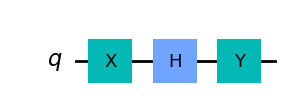

In [8]:
target_circuit = QuantumCircuit(1)
target_circuit.x(0)
target_circuit.h(0)
target_circuit.y(0)
# target_circuit.x(1)
print("Initital Circuit")
target_circuit.draw("mpl")

Transpile the (context) quantum circuit to the provided (Fake-) Backend

Transpiled Circuit


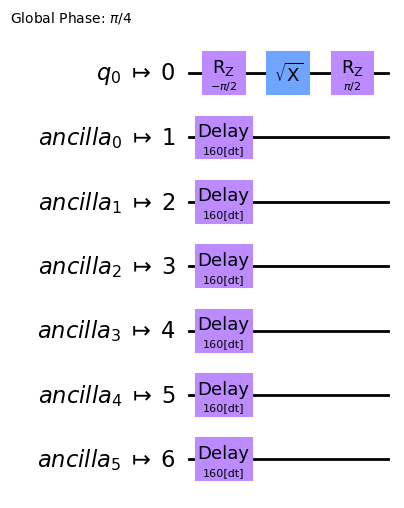

In [9]:
# target_circuit.measure_all()
transpiled_circ = transpile(
    target_circuit,
    fake_backend,
    initial_layout=[0],
    basis_gates=fake_backend.configuration().basis_gates,
    scheduling_method="asap",
    optimization_level=1,
)
print("Transpiled Circuit")
remove_unused_wires(transpiled_circ).draw("mpl")

Visualization of the "context" quantum circuit as a pulse sequence that the parametrized SX gate will then be added to

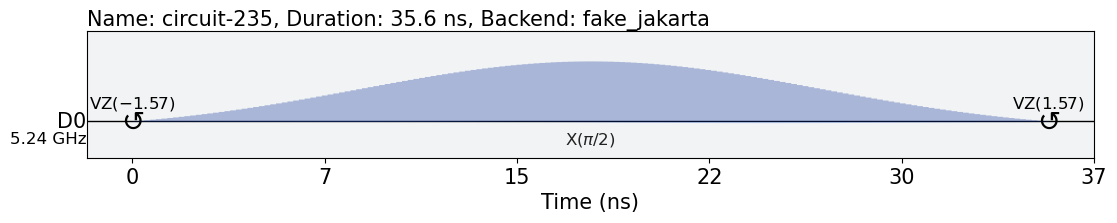

In [10]:
# schedule = build_schedule(transpiled_circ, fake_backend)
sched01 = schedule(transpiled_circ, fake_backend)
sched01.draw(backend=fake_backend, style=IQXStandard())

In [11]:
n_actions = 3  # number of parameters for the SX gate : amplitude and angle
print("Target gate:", target)

params = ParameterVector("theta", n_actions)

qubit = target["register"]
physical_qubits = tuple(qubit)

Target gate: {'gate': Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), 'register': [0]}


Add the parameterized SX gate to the quantum circuit, so that it exists in the context (=presence) of prior gates

In [12]:
# add_parametrized_circuit(qc=transpiled_circ, tgt_register=target['register'])
# print('Transpiled Circuit')
# transpiled_circ.draw('mpl')

In [13]:
default_params, instructions, pulses = get_sx_params(
    backend=fake_backend, physical_qubits=physical_qubits
)

Visualization of the target SX Pulse (it's a Derivative Removal by Adiabatic Gate (DRAG) pulse)

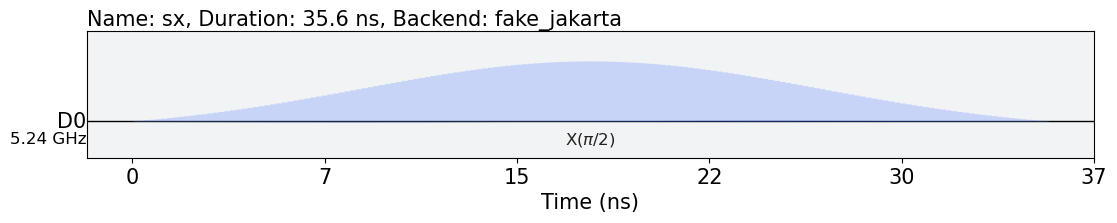

In [14]:
instructions.draw(backend=fake_backend, style=IQXStandard())

Visualization of the pulse sequence for the parameterized gate within the full circuit context

In [15]:
# sched02 = schedule(transpiled_circ, fake_backend)
# sched02.draw(backend=fake_backend, style=IQXStandard())

#### Plug it into ``QuantumEnvironment``

In [28]:
sampling_Paulis = 50
N_shots = 200
n_actions = 4  # Cf number of parameters in custom_schedule function above
abstraction_level = "pulse"

In [29]:
control_channel_map = get_control_channel_map(fake_backend, physical_qubits)
print("control_channel_map", control_channel_map)
dt = fake_backend.configuration().dt

dynamics_options = {
    "seed_simulator": None,  # "configuration": fake_backend.configuration(),
    "solver_options": {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt},
}
qubit_properties = fake_backend_v2.qubit_properties(physical_qubits)

# Extract channel frequencies and Solver instance from backend to provide a pulse level simulation enabling
# fidelity benchmarking
channel_freq, solver = get_solver_and_freq_from_backend(
    backend=fake_backend,
    subsystem_list=physical_qubits,
    rotating_frame="auto",
    evaluation_mode="dense",
    rwa_cutoff_freq=None,
    static_dissipators=None,
    dissipator_channels=None,
    dissipator_operators=None,
)
calibration_files = None

{(0, 1): 0, (1, 0): 1, (5, 6): 10, (6, 5): 11, (1, 2): 2, (1, 3): 3, (2, 1): 4, (3, 1): 5, (3, 5): 6, (4, 5): 7, (5, 3): 8, (5, 4): 9}
control_channel_map {}


In [30]:
estimator_options = Options(
    resilience_level=0,
    optimization_level=0,
    execution=ExecutionOptions(shots=N_shots * sampling_Paulis),
)

Creat a solver instead of creating a DynmamicsBacked.from_backend()

In [31]:
dim = 3

v = [prop.frequency for prop in qubit_properties]
v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)

static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = (
    static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))
)

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

# build solver
dt = 1 / 4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[
        drive_op0,
        drive_op1,
        drive_op0,
        drive_op1,
        drive_op1,
        drive_op0,
    ],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1", "u2", "u3"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0, "u2": v0, "u3": v1},
    dt=dt,
    evaluation_mode="sparse",
)
# Consistent solver option to use throughout notebook
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8}

custom_backend2 = DynamicsBackend(
    solver=solver,
    # target = fake_backend_v2.target,
    subsystem_dims=[dim, dim],  # for computing measurement data
    solver_options=solver_options,  # to be used every time run is called
)
backend_target = custom_backend2.target
channel_freq = None
calibration_files = None
do_calibrations = True
# qubit properties

In [32]:
# dynamics_backend = custom_backend2

In [65]:
# subsystem_list takes the qubits indices that are the qubits with the parametrized gate AND its nearest neighbours
dynamics_backend = DynamicsBackend.from_backend(
    fake_backend, subsystem_list=(0, 1), **dynamics_options
)
dynamics_backend.target.qubit_properties = qubit_properties
# list(dynamics_backend.coupling_map)

In [66]:
from helper_functions import retrieve_backend_info
from qiskit_experiments.framework import BackendData
from qiskit_ibm_runtime import Estimator as Runtime_Estimator

Manually populate the coupling map of the ``DynamicsBackend`` with the data from the ``fake_backend``

In [67]:
# Wrap all info in one QiskitConfig
# Qiskit_setup = QiskitConfig(parametrized_circuit=apply_parametrized_circuit, backend=backend)
Qiskit_setup = QiskitConfig(
    parametrized_circuit=add_parametrized_circuit,
    backend=dynamics_backend,
    estimator_options=estimator_options,
    channel_freq=channel_freq,
    solver=solver,
)
Qiskit_setup

QiskitConfig(parametrized_circuit=<function add_parametrized_circuit at 0x7fef7988daf0>, backend=<qiskit_dynamics.backend.dynamics_backend.DynamicsBackend object at 0x7fef6ae11c70>, estimator_options=Options(optimization_level=0, resilience_level=0, max_execution_time=None, transpilation=TranspilationOptions(skip_transpilation=False, initial_layout=None, layout_method=None, routing_method=None, approximation_degree=None), resilience=ResilienceOptions(noise_amplifier=None, noise_factors=None, extrapolator=None), execution=ExecutionOptions(shots=10000, init_qubits=True), environment=EnvironmentOptions(log_level='WARNING', callback=None, job_tags=[]), simulator=SimulatorOptions(noise_model=None, seed_simulator=None, coupling_map=None, basis_gates=None)), solver=<qiskit_dynamics.solvers.solver_classes.Solver object at 0x7fef5dec9fd0>, channel_freq=None, do_calibrations=True, calibration_files=None)

In [68]:
physical_qubits

(0,)

In [69]:
print(dynamics_backend.options.control_channel_map)

{(0, 1): 0, (1, 0): 1, (1, 2): 2, (1, 3): 3}


In [38]:
dynamics_backend.num_qubits

7

In [39]:
q_env = QuantumEnvironment(
    target=target,
    abstraction_level=abstraction_level,
    Qiskit_config=Qiskit_setup,
    sampling_Pauli_space=sampling_Paulis,
    n_shots=N_shots,
    c_factor=0.5,
)

{(0, 1): 0}
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'s', 'rz', 'measure', 'tdg', 'z', 't', 'h', 'sx', 'reset', 'delay', 'id', 'x', 'sdg'}
  q1: {'s', 'rz', 'measure', 'tdg', 'z', 't', 'h', 'sx', 'reset', 'delay', 'id', 'x', 'sdg'}
  q2: {'s', 'rz', 'measure', 'tdg', 'z', 't', 'h', 'delay', 'reset', 'id', 'sdg'}
  q3: {'s', 'rz', 'measure', 'tdg', 'z', 't', 'h', 'delay', 'reset', 'id', 'sdg'}
  q4: {'s', 'rz', 'measure', 'tdg', 'z', 't', 'h', 'delay', 'reset', 'id', 'sdg'}
  q5: {'s', 'rz', 'measure', 'tdg', 'z', 't', 'h', 'delay', 'reset', 'id', 'sdg'}
  q6: {'s', 'rz', 'measure', 'tdg', 'z', 't', 'h', 'delay', 'reset', 'id', 'sdg'}
Multi qubit instructions:
  (0, 1): {'cr45p', 'cr45m', 'ecr'}
)>


In [40]:
"""
job = dynamics_backend.run(transpiled_circ)
results = job.result()
results.get_counts()
"""

'\njob = dynamics_backend.run(transpiled_circ)\nresults = job.result()\nresults.get_counts()\n'

### Access Coupling Map of the Backend

In [41]:
dt, coupling_map, basis_gates, instruction_durations = retrieve_backend_info(
    backend=dynamics_backend
)

In [42]:
list(coupling_map)

[(0, 1)]

In [43]:
seed = 10
training_steps_per_gate = 2000
benchmark_cycle = 100
# tgt_instruction_counts = target_circuit.data.count(CircuitInstruction(target_gate, tgt_qubits))
tgt_instruction_counts = 2  # Number of times target Instruction is applied in Circuit
batchsize = 200  # Batch size (iterate over a bunch of actions per policy to estimate expected return) default 100
n_actions = 4  # Choose how many control parameters in pulse/circuit parametrization
min_bound_actions = -0.1
max_bound_actions = 0.1
scale_factor = 0.1
observation_space = Box(
    low=np.array([0, 0]),
    high=np.array([1, tgt_instruction_counts]),
    shape=(2,),
    seed=seed,
)
action_space = Box(
    low=min_bound_actions, high=max_bound_actions, shape=(n_actions,), seed=seed
)

/Users/arthurstrauss/opt/anaconda3/envs/rl_qoc/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [44]:
torch_env = TorchQuantumEnvironment(
    q_env,
    target_circuit,
    action_space,
    observation_space,
    batch_size=batchsize,
    training_steps_per_gate=training_steps_per_gate,
    benchmark_cycle=benchmark_cycle,
    intermediate_rewards=False,
    seed=None,
)

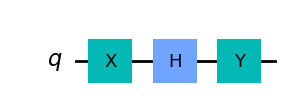

In [45]:
target_circuit.draw("mpl")

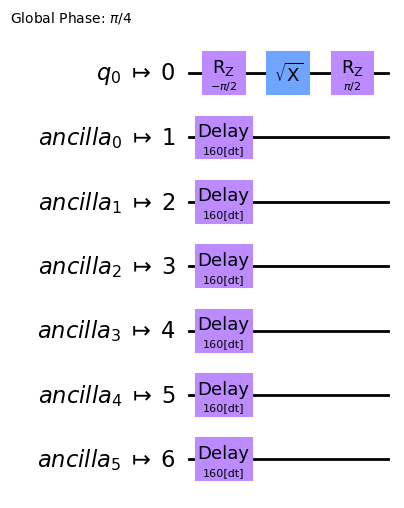

In [46]:
transpiled_circ.draw("mpl")

In [47]:
torch_env.circuit_context.calibrations

{'x': {((0,),
   ()): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-4.2212991914, amp=0.17444652, angle=0), DriveChannel(0)), name="x", transform=AlignLeft())},
 'h': {((0,),
   ()): ScheduleBlock(ScheduleBlock(ShiftPhase(-1.5707963268, DriveChannel(0)), name="rz0", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=0, amp=0.08722326, angle=0), DriveChannel(0)), name="sx", transform=AlignLeft()), ScheduleBlock(ShiftPhase(-1.5707963268, DriveChannel(0)), name="rz0", transform=AlignLeft()), name="h", transform=AlignLeft())},
 'z': {((0,),
   ()): ScheduleBlock(ShiftPhase(-3.1415926536, DriveChannel(0)), name="rz0", transform=AlignLeft())}}

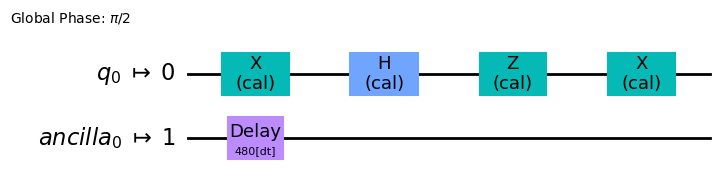

In [48]:
torch_env.circuit_context.draw("mpl")

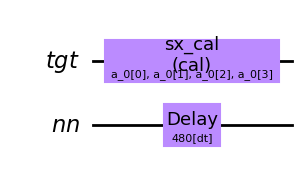

In [49]:
torch_env.circuit_truncations[0].draw("mpl")

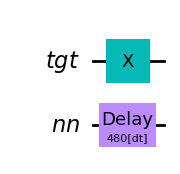

In [50]:
torch_env.baseline_truncations[0].draw("mpl")

# Reinforcement Learning

#### Definition of the Agent

In [51]:
import torch
import torch.nn as nn

from agent import ActorNetwork, CriticNetwork, Agent

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
hidden_units = [64, 64]
activation_functions = [nn.Tanh(), nn.Tanh(), nn.Tanh()]
include_critic = False
chkpt_dir = "tmp/ppo"
chkpt_dir_critic = "tmp/critic_ppo"

actor_net = ActorNetwork(
    observation_space,
    hidden_units,
    n_actions,
    activation_functions,
    include_critic,
    chkpt_dir,
).to(device)
critic_net = CriticNetwork(
    observation_space, hidden_units, activation_functions, chkpt_dir_critic
).to(device)
agent = Agent(actor_net, critic_net=critic_net).to(device)

In [52]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""

from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

run_name = "test"
writer = SummaryWriter(f"runs/{run_name}")
# writer.add_text(
#     "hyperparameters",
#     "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
# )
# Hyperparameters for the agent
n_epochs = 10  # Number of epochs : default 1500
num_updates = 700
lr_actor = 0.001  # Learning rate for policy update step
lr_critic = 0.001  # Learning rate for critic (value function) update step

epsilon = 0.2  # Parameter for clipping value (PPO)
critic_loss_coeff = 0.5
optimizer = optim.Adam(agent.parameters(), lr=lr_actor, eps=1e-5)
actor_optimizer = optim.Adam(actor_net.parameters(), lr=lr_actor, eps=1e-5)
critic_optimizer = optim.Adam(critic_net.parameters(), lr=lr_critic, eps=1e-5)
minibatch_size = 40
gamma = 1.0
gae_lambda = 0.95

# Clipping
clip_vloss = True
grad_clip = 0.5
clip_coef = 0.5
normalize_advantage = False

# other coefficients
ent_coef = 0.0

In [53]:
torch_env.episode_length

<bound method TorchQuantumEnvironment.episode_length of QuantumEnvironment composed of 1 qubits, 
Defined target: gate (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]))
Physical qubits: [0]
Backend: <qiskit_dynamics.backend.dynamics_backend.DynamicsBackend object at 0x7fef5dd95be0>,
Abstraction level: pulse,
Run options: N_shots (200), Sampling_Pauli_space (50), 
Batchsize: 200, 
Number of target gates in circuit context: 2
>

### Training

In [54]:
global_step = 0
torch_env.clear_history()
obs = torch.zeros(
    (tgt_instruction_counts, batchsize) + torch_env.observation_space.shape
).to(device)
actions = torch.zeros(
    (tgt_instruction_counts, batchsize) + torch_env.action_space.shape
).to(device)
logprobs = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
rewards = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
dones = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
values = torch.zeros((tgt_instruction_counts, batchsize)).to(device)

train_obs = torch.zeros(
    (batchsize,) + torch_env.observation_space.shape, requires_grad=True
).to(device)
visualization_steps = 10

In [55]:
for update in tqdm.tqdm(range(1, num_updates + 1)):
    next_obs, _ = torch_env.reset(seed=seed)
    num_steps = torch_env.episode_length(global_step)
    next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
    next_done = torch.zeros(batchsize).to(device)

    # print("episode length:", num_steps)

    for step in range(num_steps):
        global_step += 1
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            # print('next_obs', next_obs)
            # print('agend(next_obs)', agent(next_obs))
            mean_action, std_action, critic_value = agent(next_obs)
            mean_action *= scale_factor
            probs = Normal(mean_action, std_action)
            action = torch.clip(
                probs.sample(),
                torch.Tensor(np.array(min_bound_actions)),
                torch.Tensor(np.array(max_bound_actions)),
            )
            logprob = probs.log_prob(action).sum(1)
            values[step] = critic_value.flatten()

        actions[step] = action
        logprobs[step] = logprob
        # next_obs, reward, terminated, truncated, infos = torch_env.step(action.cpu().numpy())
        next_obs, reward, terminated, truncated, infos = torch_env.step(
            action.cpu().numpy()
        )
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device)
        next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
        next_done = torch.Tensor(np.array([int(done)] * batchsize)).to(device)
        # Only print when at least 1 env is done

        # print(f"global_step={global_step}, episodic_return={np.mean(reward)}")
        writer.add_scalar("charts/episodic_return", np.mean(reward), global_step)
        writer.add_scalar("charts/episodic_length", num_steps, global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = (
                delta + gamma * gae_lambda * nextnonterminal * lastgaelam
            )
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + torch_env.observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + torch_env.action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batchsize)
    clipfracs = []
    for epoch in range(n_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batchsize, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]
            new_mean, new_sigma, new_value = agent(b_obs[mb_inds])
            new_dist = Normal(new_mean, new_sigma)
            new_logprob, entropy = new_dist.log_prob(b_actions[mb_inds]).sum(
                1
            ), new_dist.entropy().sum(1)
            logratio = (
                new_logprob - b_logprobs[mb_inds] + torch.log(torch.Tensor([1e-6]))
            )
            ratio = logratio.exp()
            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > epsilon).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if normalize_advantage:  # Normalize advantage
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (
                    mb_advantages.std() + 1e-8
                )

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = new_value.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * critic_loss_coeff

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), grad_clip)
            optimizer.step()

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y
    print("mean", mean_action[0])
    print("sigma", std_action[0])
    print("Average return:", np.mean(torch_env.reward_history, axis=1)[-1])
    # print(np.mean(torch_env.reward_history, axis =1)[-1])
    # print("Circuit fidelity:", torch_env.circuit_fidelity_history[-1])
    # print("Avg gate fidelity:", torch_env.avg_fidelity_history[-1])
    print(torch_env._get_info())
    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar(
        "charts/learning_rate", optimizer.param_groups[0]["lr"], global_step
    )
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar(
        "losses/avg_return", np.mean(torch_env.reward_history, axis=1)[-1], global_step
    )
    # for i in range(num_steps):
    #   writer.add_scalar(f"losses/avg_gate_{i}_fidelity", torch_env.avg_fidelity_history[-1][i], global_step)
    # writer.add_scalar("losses/circuit_fidelity", torch_env.circuit_fidelity_history[-1], global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    if global_step % visualization_steps == 0:
        clear_output(wait=True)  # for animation

torch_env.close()
writer.close()

  3%|█▏                                      | 20/700 [03:00<2:29:50, 13.22s/it]

Sending job...


  3%|█▏                                      | 21/700 [03:09<2:14:03, 11.85s/it]

Job done
mean tensor([ 0.0074, -0.0007,  0.0018,  0.0012])
sigma tensor([0.4453, 0.4261, 0.4022, 0.5248])
Average return: 0.0
{'reset_stage': False, 'step': 21, 'average return': 0.0, 'max return': 3.9993875, 'arg_max return': 10, 'best action': array([-7.02872686e-05,  4.73798462e-03, -2.41908184e-03,  1.39347381e-03]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[2, 1]', 'observable': SparsePauliOp(['II', 'IX', 'ZI', 'ZX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j])}
Sending job...


  3%|█▎                                      | 22/700 [03:20<2:12:32, 11.73s/it]

Job done
mean tensor([ 0.0081, -0.0004,  0.0017,  0.0021])
sigma tensor([0.4429, 0.4225, 0.3955, 0.5278])
Average return: 3.999358823529412
{'reset_stage': False, 'step': 22, 'average return': 3.999358823529412, 'max return': 3.9993875, 'arg_max return': 10, 'best action': array([-7.02872686e-05,  4.73798462e-03, -2.41908184e-03,  1.39347381e-03]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[2, 2]', 'observable': SparsePauliOp(['II', 'IX', 'XI', 'XX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])}
Sending job...


  3%|█▎                                      | 23/700 [03:32<2:11:58, 11.70s/it]

Job done
mean tensor([0.0101, 0.0006, 0.0006, 0.0058])
sigma tensor([0.4259, 0.4024, 0.3614, 0.5355])
Average return: 1.90518
{'reset_stage': False, 'step': 23, 'average return': 1.90518, 'max return': 3.9993875, 'arg_max return': 10, 'best action': array([-7.02872686e-05,  4.73798462e-03, -2.41908184e-03,  1.39347381e-03]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[3, 3]', 'observable': SparsePauliOp(['II', 'IY', 'YI', 'YY'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j])}
Sending job...


  3%|█▎                                      | 24/700 [03:40<1:59:11, 10.58s/it]

Job done
mean tensor([ 0.0061, -0.0007,  0.0014,  0.0006])
sigma tensor([0.4389, 0.4192, 0.3958, 0.5199])
Average return: 0.0
{'reset_stage': False, 'step': 24, 'average return': 0.0, 'max return': 3.9993875, 'arg_max return': 10, 'best action': array([-7.02872686e-05,  4.73798462e-03, -2.41908184e-03,  1.39347381e-03]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[2, 1]', 'observable': SparsePauliOp(['II', 'IX', 'ZI', 'ZX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j])}
Sending job...


  3%|█▎                                      | 24/700 [03:47<1:46:51,  9.48s/it]


KeyboardInterrupt: 